In [1]:
# Import python packages
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

# We can also use Snowpark for our analyses!
# from snowflake.snowpark.context import get_active_session //For Snowsight
# session = get_active_session() //For Snowsight

from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
session = Session.builder.config("connection_name", "myconnection").create()

In [2]:
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : PRATIKDAVIDSON
Role                        : "ACCOUNTADMIN"
Database                    : "SNOWFLAKE_ML_DB"
Schema                      : "SNOWFLAKE_ML_SCHEMA"
Warehouse                   : "SNOWFLAKE_ML_WH"
Snowflake version           : 8.28.0
Snowpark for Python version : 1.20.0


In [3]:
# Show the file before loading
session.sql("LS @DAILY_DELHI_CLIMATE_ASSETS;").show()

# Create a Snowpark DataFrame that is configured to load data from the CSV file
# We can now infer schema from CSV files.
train_df = session.read.options({"field_delimiter": ",",
                                    "field_optionally_enclosed_by": '"',
                                    "infer_schema": True,
                                    "parse_header": True}).csv("@DAILY_DELHI_CLIMATE_ASSETS/DailyDelhiClimateTrain.csv.gz")

test_df = session.read.options({"field_delimiter": ",",
                                    "field_optionally_enclosed_by": '"',
                                    "infer_schema": True,
                                    "parse_header": True}).csv("@DAILY_DELHI_CLIMATE_ASSETS/DailyDelhiClimateTest.csv.gz")

---------------------------------------------------------------------------------------------------------------------------------
|"name"                                              |"size"  |"md5"                             |"last_modified"               |
---------------------------------------------------------------------------------------------------------------------------------
|daily_delhi_climate_assets/DailyDelhiClimateTes...  |2032    |48eb548d6767a2e02cbc8586948ca3c0  |Sat, 3 Aug 2024 11:07:42 GMT  |
|daily_delhi_climate_assets/DailyDelhiClimateTra...  |19632   |7f361bb0581ce7ca45fe38c6bbf70f5d  |Sat, 3 Aug 2024 11:07:40 GMT  |
---------------------------------------------------------------------------------------------------------------------------------



In [4]:
# Tables need column names to be in upper case
for colname in train_df.columns:
    new_colname = str.upper(colname)
    train_df = train_df.with_column_renamed(colname, new_colname)
    test_df = test_df.with_column_renamed(colname, new_colname)

train_df.columns

['DATE', 'MEANTEMP', 'HUMIDITY', 'WIND_SPEED', 'MEANPRESSURE']

In [5]:
# Remove extra unwanted data
train_df = train_df.filter(F.col("DATE") != '2017-01-01')

In [6]:
# Load data to tables
train_df.write.mode('overwrite').save_as_table('train_data')
test_df.write.mode('overwrite').save_as_table('test_data')

# Execute the below cells after training and predicting from Cortex ML or using cortex_ml_forecast.sql

In [7]:
train_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.TRAIN_DATA"
test_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.TEST_DATA"
forecast_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.MEAN_TEMP_FORECAST"

In [8]:
# Load data from tables as pandas dataframe
train_pdf = session.table(train_tbl).to_pandas()
test_pdf = session.table(test_tbl).to_pandas()
forecast_pdf = session.table(forecast_tbl).to_pandas()

In [9]:
# Excluded the time from datetime data format
forecast_pdf['TS'] = forecast_pdf['TS'].dt.date

<Axes: xlabel='DATE', ylabel='MEANTEMP'>

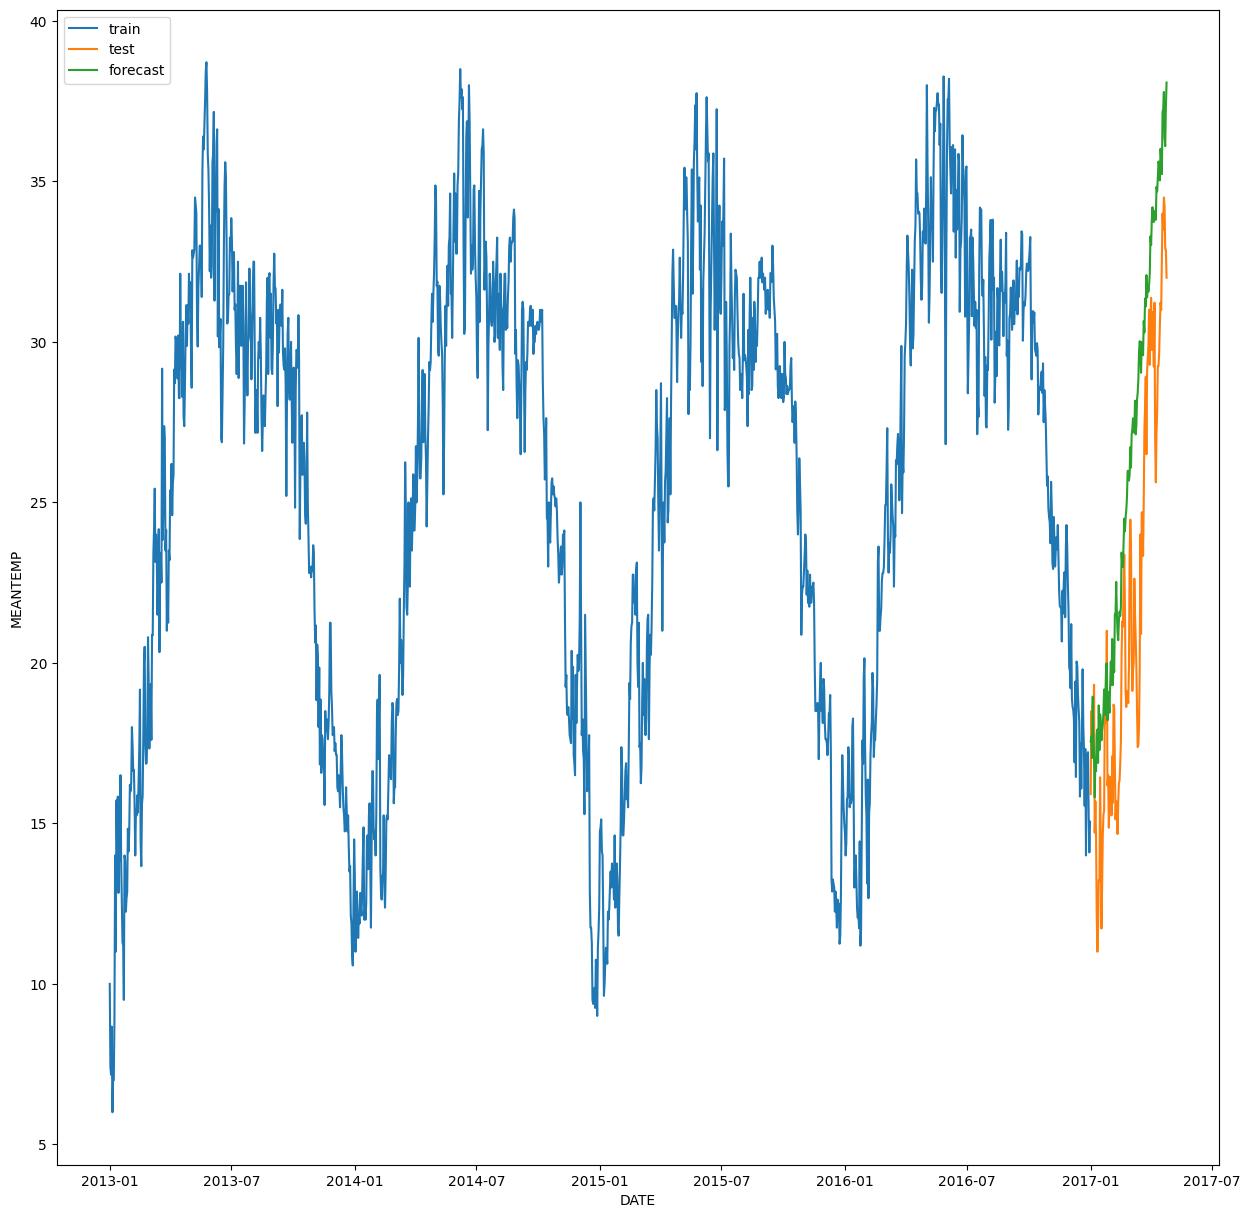

In [10]:
# Plot line graph to visualize the predicted data against the test data
plt.figure(figsize=(15, 15))
sns.lineplot(data=train_pdf, x='DATE', y='MEANTEMP', label='train')
sns.lineplot(data=test_pdf, x='DATE', y='MEANTEMP', label='test')
sns.lineplot(data=forecast_pdf, x='TS', y='FORECAST', label='forecast')